# **Notebook for creating clustermaps from lineageTree data**

This notebook is an example of how we can use tree edit distances to create clustermaps, like the next one

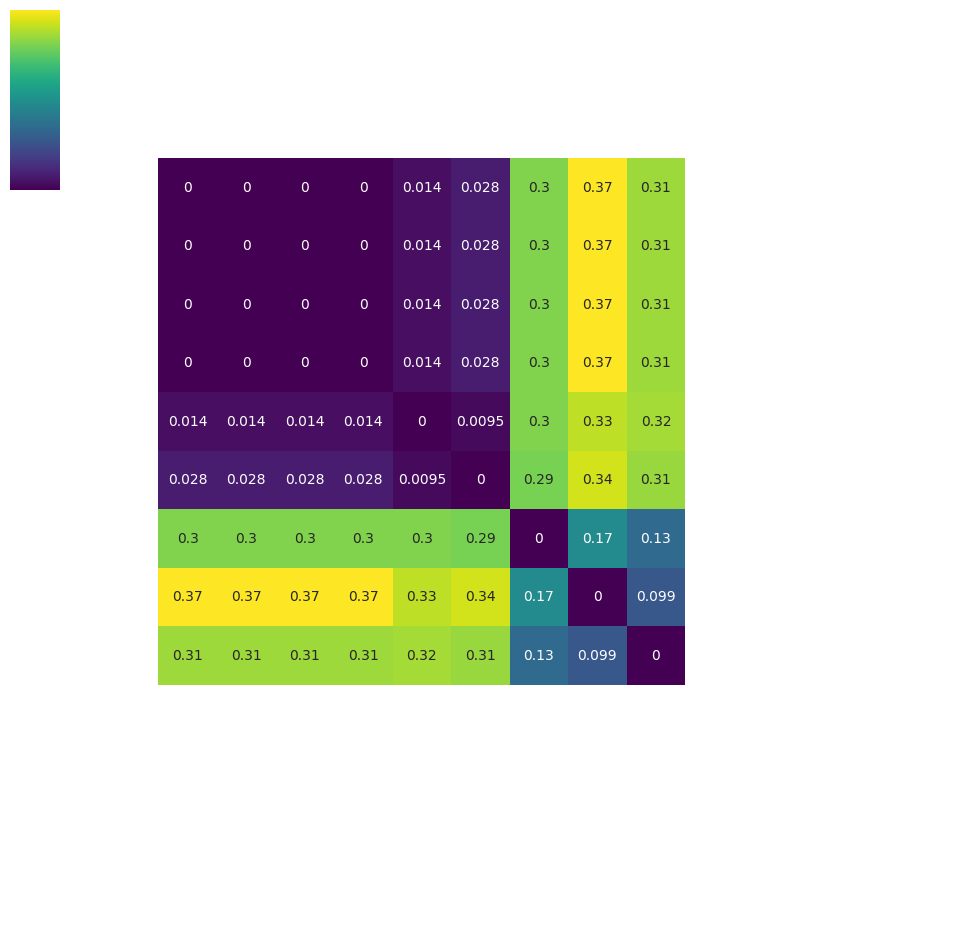

Importing important packages

In [1]:
from LineageTree import lineageTree, lineageTreeManager
from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform

try:
    import seaborn as sns
except:
    !pip install seaborn
finally:
    import seaborn as sns
    import matplotlib.pyplot as plt
    from itertools import combinations
    import numpy as np

Load the manager

In [2]:
lT1 = lineageTree.load("../test/data/test-mamut.lT")
lT2 = lineageTree.load("../test/data/demo.lT")
lTm = lineageTreeManager()
lTm.add(lT1)
lTm.add(lT2)

### Or load a manager###

# lTm = lineageTreeManager.load("path_to/Manager.ltM")

/home/giannis/programs/tree_stuff/LineageTree/src/LineageTree/lineageTree.py:1955: UserWarning: Empty lists have been removed
  warnings.warn("Empty lists have been removed")


In [3]:
lTm.lineagetrees.keys()

dict_keys(['test-mamut', 'Lineagetree 0'])

Labels can and should be changed


In [4]:
lTm.lineagetrees["test-mamut"].labels, lTm.lineagetrees["Lineagetree 0"].labels

({132129: 'Unlabeled',
  168322: 'Unlabeled',
  110826: 'Unlabeled',
  110832: 'Unlabeled',
  173618: 'Unlabeled',
  132063: 'Unlabeled'},
 {176: 'Unlabeled', 29345: 'Unlabeled', 38764: 'Unlabeled'})

In [5]:
for lT in lTm.lineagetrees.values():
    for i, root in enumerate(lT.roots):
        lT.labels[root] = f"Label {i}"

### Select only labeled roots (Next 2 cells can be replaced by just making a list of ids)

In [6]:
roots = {}
for lt in lTm.lineagetrees:
    for root in lTm.lineagetrees[lt].labels:
        if (
            lTm.lineagetrees[lt].labels[root] != "Unlabeled"
            and lTm.lineagetrees[lt].time[root] == 0
        ):
            roots.setdefault(lt, []).append(root)
roots

{'test-mamut': [132129, 168322, 110826, 110832, 173618, 132063],
 'Lineagetree 0': [176, 29345, 38764]}

In [7]:
time = 0  # Select a specific time point
comparisons = {}
names = {}
all_roots = [
    (
        lt,
        selected_root,
        int(node),
    )
    for lt in roots
    for node in roots[lt]
    for selected_root in lTm.lineagetrees[lt].get_cells_at_t_from_root(
        int(node), time
    )
]
names = dict(enumerate(all_roots))
combs = combinations(names.keys(), 2)
combs = list(combs)

# Otherwise create a list that contains tuples: 
```python
[
    ("name_of_lT", node, root),
    ("name_of_lT", node, root),
    ("name_of_lT", node, root),
    ("name_of_lT", node, root),
    ....
]

### Comparison calculation

In [8]:
comparison = {}
for i, (n1, n2) in enumerate(combs):
    comparison[n1, n2] = lTm.cross_lineage_edit_distance(
        names[n1][1],
        names[n1][0],
        100,
        names[n2][1],
        names[n2][0],
        100,
        node_lengths=(1, 3, 7),  # optional for fragmented
        style="simple",  # Best style option for speed and accuracy is "fragmented"
    )

### Calculation of the hierarchy clustermap

In [9]:
combs = combinations(names, 2)
labels = [
    node[0][:-6]
    + "_"
    + lTm.lineagetrees[node[0]].labels[
        lTm.lineagetrees[node[0]].get_labelled_ancestor(node[1])
    ]
    for node in names.values()
]
hierarchy = np.zeros((len(names), len(names)))
keys = comparison.keys()
values = comparison.values()
for keys, values in combs:
    hierarchy[keys, values] = comparison[(keys, values)]
    hierarchy[values, keys] = comparison[(keys, values)]
condensed_dist_matrix = squareform(hierarchy)
linkage_data = linkage(condensed_dist_matrix, method="ward")

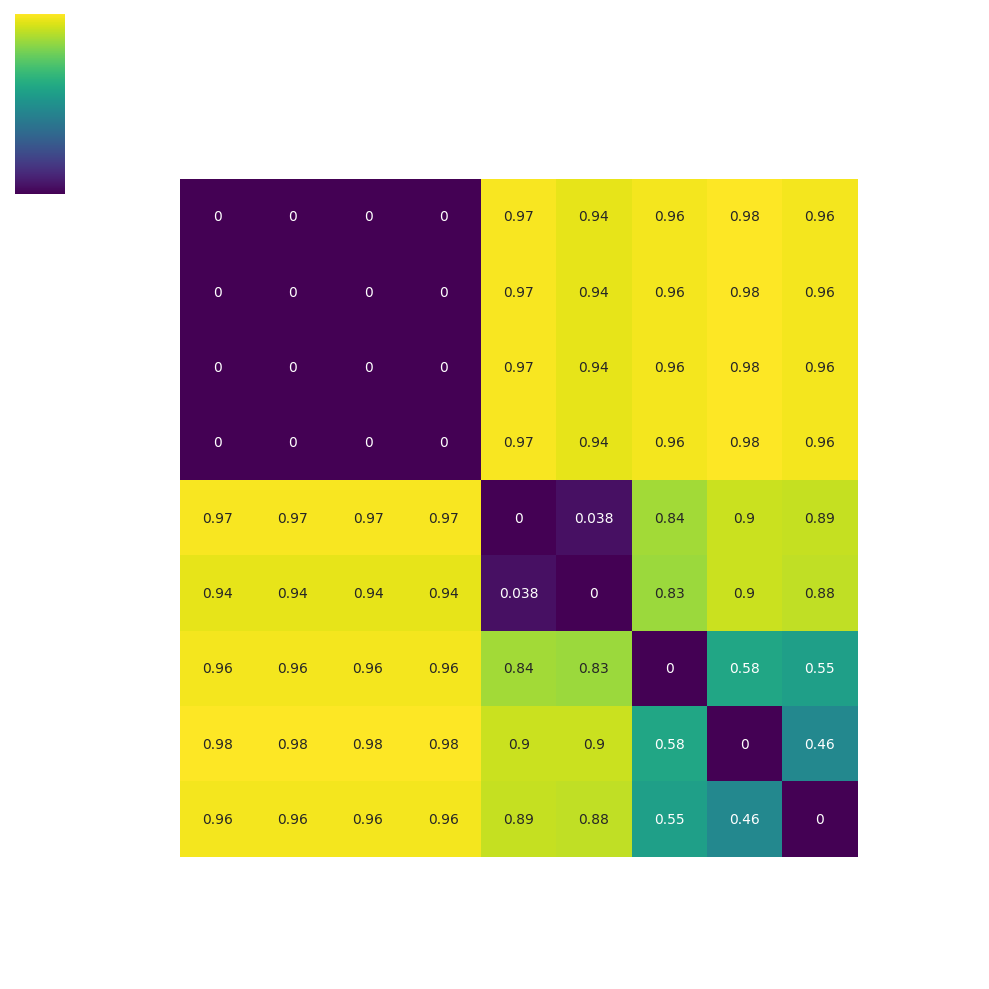

In [10]:
g = sns.clustermap(
    hierarchy,
    xticklabels=[label for label in labels],  # labels,
    yticklabels=[label for label in labels],
    cmap="viridis",
    row_linkage=linkage_data,
    col_linkage=linkage_data,
    annot=True,
    annot_kws={"size": 10},
)
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), color="white")
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), color="white")
g.ax_heatmap.set_facecolor("black")
g.ax_row_dendrogram.set_facecolor("black")
g.ax_col_dendrogram.set_facecolor("black")

g.ax_heatmap.tick_params(axis="both", colors="white")

for tree in g.ax_row_dendrogram.collections:
    tree.set_color("white")
for tree in g.ax_col_dendrogram.collections:
    tree.set_color("white")

g.figure.patch.set_facecolor("black")

colorbar = g.cax
colorbar.set_facecolor("black")
colorbar.tick_params(colors="white")
colorbar.yaxis.set_tick_params(color="white")

colorbar.yaxis.label.set_color("white")


g.figure.patch.set_alpha(0.0)
g.ax_heatmap.patch.set_alpha(0.0)
g.ax_row_dendrogram.patch.set_alpha(0.0)
g.ax_col_dendrogram.patch.set_alpha(0.0)
colorbar.patch.set_alpha(0.0)
plt.show()